<a href="https://colab.research.google.com/github/abhigoel25/UnderwaterTrashDetection/blob/main/UnderwaterTrashDetectionCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [2]:
import ultralytics
import torch
import pandas as pd
import numpy as np
import torchvision

from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor, transforms
import torchvision.transforms as T
from torchvision.transforms import functional as F

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from google.colab import drive
import os
import xml.etree.ElementTree as ET
from PIL import Image
drive.mount('/content/drive')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Mounted at /content/drive
Using cuda device


In [3]:
training_path = '/content/drive/MyDrive/Pioneer_Dataset/train'
testing_path = '/content/drive/MyDrive/Pioneer_Dataset/test'
validation_path = '/content/drive/MyDrive/Pioneer_Dataset/val'

In [4]:
class_names = ['plastic', 'bio', 'rov']
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

class TrainDataset(Dataset):
  def __init__(self, images_dir, annotations_dir, transform=None):
      self.images_dir = images_dir
      self.annotations_dir = annotations_dir
      self.transform = transform
      self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

  def __len__(self):
      return len(self.image_files)

  def __getitem__(self, idx):
      image_file = self.image_files[idx]
      image_path = os.path.join(self.images_dir, image_file)
      if image_file.endswith('.jpg'):
         annotation_path = os.path.join(self.annotations_dir, image_file.replace('.jpg', '.xml'))

      image = Image.open(image_path).convert("RGB")
      labels = []

      if os.path.exists(annotation_path):
          tree = ET.parse(annotation_path)
          root = tree.getroot()
          for obj in root.findall('object'):
              labelFile = []
              label = obj.find('name').text
              if(label in class_to_idx):
                labels.append(class_to_idx[label])
                break
          if not labels:
                print(f"No valid labels found for image: {image_file}")
                return self.__getitem__((idx + 1) % len(self))
      else:
        print(f"Annotation file missing for image: {image_file}")
        return self.__getitem__((idx + 1) % len(self))

      labels = torch.tensor(labels)

      if self.transform:
        image = self.transform(image)

      return image, labels


images_dir = training_path
annotations_dir = training_path
transform = transforms.Compose([
    transforms.Resize((270, 480)),
    transforms.ToTensor()])
train_dataset = TrainDataset(images_dir, annotations_dir, transform)
train_dataloader = DataLoader(train_dataset, batch_size =16, shuffle=True)

In [5]:
class_names = ['plastic', 'bio', 'rov']
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

class ValDataset(Dataset):
  def __init__(self, images_dir, annotations_dir, transform=None):
      self.images_dir = images_dir
      self.annotations_dir = annotations_dir
      self.transform = transform
      self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

  def __len__(self):
      return len(self.image_files)

  def __getitem__(self, idx):
      image_file = self.image_files[idx]
      image_path = os.path.join(self.images_dir, image_file)
      if image_file.endswith('.jpg'):
         annotation_path = os.path.join(self.annotations_dir, image_file.replace('.jpg', '.xml'))

      image = Image.open(image_path).convert("RGB")
      labels = []

      if os.path.exists(annotation_path):
          tree = ET.parse(annotation_path)
          root = tree.getroot()
          for obj in root.findall('object'):
              labelFile = []
              label = obj.find('name').text
              if(label in class_to_idx):
                labels.append(class_to_idx[label])
                break
          if not labels:
                print(f"No valid labels found for image: {image_file}")
                return self.__getitem__((idx + 1) % len(self))
      else:
        print(f"Annotation file missing for image: {image_file}")
        return self.__getitem__((idx + 1) % len(self))

      labels = torch.tensor(labels)

      if self.transform:
        image = self.transform(image)

      return image, labels


images_dir = validation_path
annotations_dir = validation_path
transform = transforms.Compose([
    transforms.Resize((270, 480)),
    transforms.ToTensor()])
val_dataset = ValDataset(images_dir, annotations_dir, transform)
val_dataloader = DataLoader(val_dataset, batch_size =16, shuffle=True)

In [6]:
class_names = ['plastic', 'bio', 'rov']
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

class TestDataset(Dataset):
  def __init__(self, images_dir, annotations_dir, transform=None):
      self.images_dir = images_dir
      self.annotations_dir = annotations_dir
      self.transform = transform
      self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

  def __len__(self):
      return len(self.image_files)

  def __getitem__(self, idx):
      image_file = self.image_files[idx]
      image_path = os.path.join(self.images_dir, image_file)
      if image_file.endswith('.jpg'):
         annotation_path = os.path.join(self.annotations_dir, image_file.replace('.jpg', '.xml'))

      image = Image.open(image_path).convert("RGB")
      labels = []

      if os.path.exists(annotation_path):
          tree = ET.parse(annotation_path)
          root = tree.getroot()
          for obj in root.findall('object'):
              labelFile = []
              label = obj.find('name').text
              if(label in class_to_idx):
                labels.append(class_to_idx[label])
                break
          if not labels:
                print(f"No valid labels found for image: {image_file}")
                return self.__getitem__((idx + 1) % len(self))
      else:
        print(f"Annotation file missing for image: {image_file}")
        return self.__getitem__((idx + 1) % len(self))

      labels = torch.tensor(labels)

      if self.transform:
        image = self.transform(image)

      return image, labels


images_dir = testing_path
annotations_dir = testing_path
transform = transforms.Compose([
    transforms.Resize((270, 480)),
    transforms.ToTensor()])
test_dataset = TestDataset(images_dir, annotations_dir, transform)
test_dataloader = DataLoader(test_dataset, batch_size =16, shuffle=True)

In [7]:
class UnderwaterTrashNN(nn.Module):
    def __init__(self):
        super(UnderwaterTrashNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(32 * 240 * 135, 64)  # 32 channels, 240x135 output size after pooling
        self.bn2 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)  # Reduce spatial dimension to 240x135
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

Epoch [1/5], Step [1/358], Loss: 1.1199
Train Accuracy: 18.75%
Train Accuracy: 28.125%
Train Accuracy: 31.25%
Train Accuracy: 32.8125%
Train Accuracy: 36.25%
Epoch [1/5], Step [6/358], Loss: 1.0740
Train Accuracy: 37.5%
Train Accuracy: 36.607142857142854%
Train Accuracy: 35.15625%
Train Accuracy: 35.416666666666664%
Train Accuracy: 36.875%
Epoch [1/5], Step [11/358], Loss: 1.1067
Train Accuracy: 37.5%
Train Accuracy: 36.979166666666664%
Train Accuracy: 36.05769230769231%
Train Accuracy: 36.607142857142854%
Train Accuracy: 36.666666666666664%
Epoch [1/5], Step [16/358], Loss: 1.0311
Train Accuracy: 37.890625%
Train Accuracy: 37.5%
Train Accuracy: 37.84722222222222%
Train Accuracy: 38.81578947368421%
Train Accuracy: 40.3125%
Epoch [1/5], Step [21/358], Loss: 0.9618
Train Accuracy: 41.36904761904762%
Train Accuracy: 41.47727272727273%
Train Accuracy: 42.66304347826087%
Train Accuracy: 43.489583333333336%
Train Accuracy: 44.25%
Epoch [1/5], Step [26/358], Loss: 0.9708
Train Accuracy: 45.19

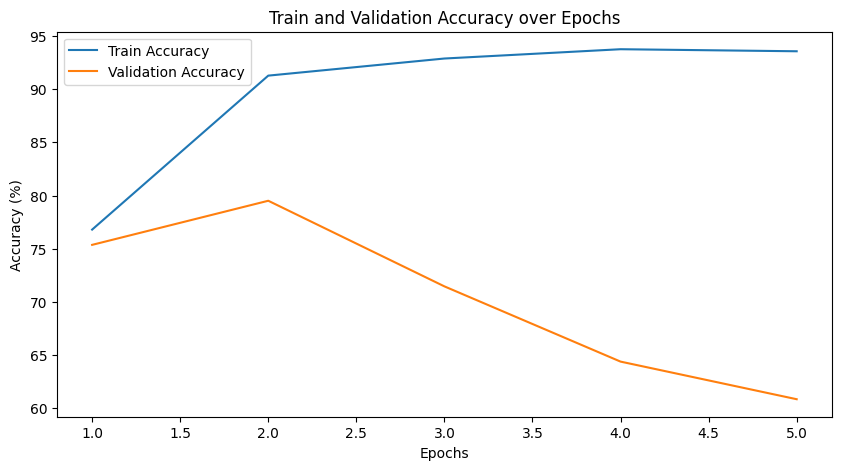

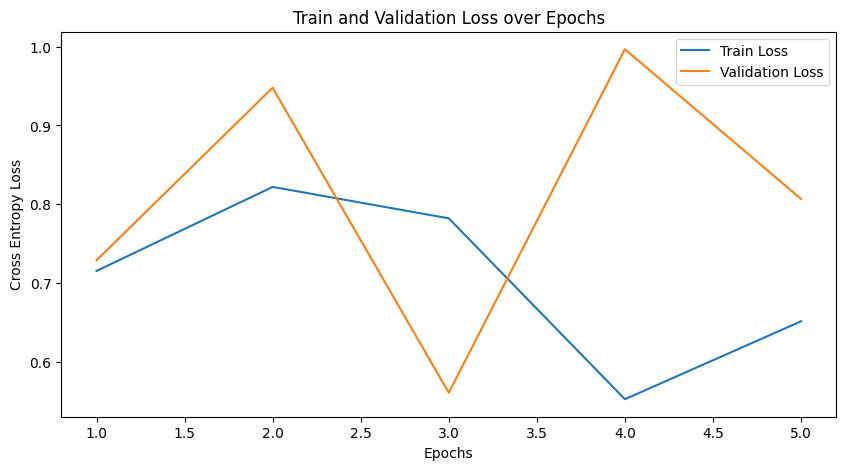

In [9]:
model = UnderwaterTrashNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_accuracies = []
val_accuracies = []
train_loss = []
val_loss = []


num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0
    correct_val = 0
    total_val = 0
    i = 0
    for step, batch in enumerate(train_dataloader):
      batch_X, batch_y = batch
      batch_X, batch_y = batch_X.to(device), batch_y.to(device)

      batch_y = batch_y.squeeze()

      # Forward pass
      outputs = model(batch_X)
      loss = criterion(outputs, batch_y)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Calculate training accuracy
      _, predicted = torch.max(outputs.data, 1)
      total_train += batch_y.size(0)
      correct_train += (predicted == batch_y).sum().item()

      if step % 5 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

      print(f"Train Accuracy: {100 * correct_train / total_train}%")

    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    train_loss.append(loss.item())


    #Validation Loop
    for step, batch in enumerate(val_dataloader):
      model.eval()

      batch_X, batch_y = batch
      batch_X, batch_y = batch_X.to(device), batch_y.to(device)
      batch_y = batch_y.squeeze()

      with torch.no_grad():
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

      _, predicted = torch.max(outputs.data, 1)
      total_val += batch_y.size(0)
      correct_val += (predicted == batch_y).sum().item()
      i += 1
      if i % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{len(val_dataloader)}], Loss: {loss.item():.4f}')

      print(f"Val Accuracy: {100 * correct_val / total_val}%")

    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    val_loss.append(loss.item())



plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_loss, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.show()

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve
from sklearn.preprocessing import label_binarize

Output Prediction: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Target Prediction: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Output Prediction: tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 2, 0, 0], device='cuda:0')
Target Prediction: tensor([0, 1, 0, 0, 0, 1, 0, 2, 0, 1, 0, 1, 0, 2, 0, 0], device='cuda:0')
Output Prediction: tensor([0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0], device='cuda:0')
Target Prediction: tensor([0, 0, 0, 1, 1, 0, 0, 1, 2, 2, 1, 0, 1, 0, 1, 0], device='cuda:0')
Output Prediction: tensor([2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Target Prediction: tensor([2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Output Prediction: tensor([0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Target Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1], device='cuda:0')
Output Prediction: tensor([1, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0

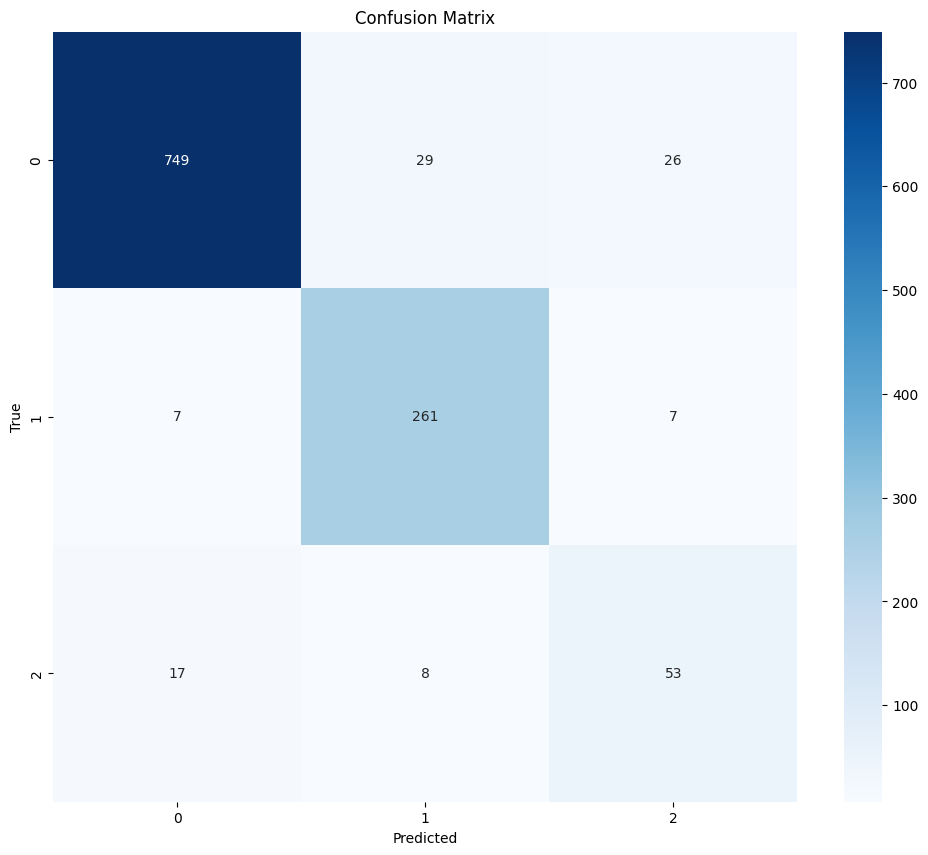

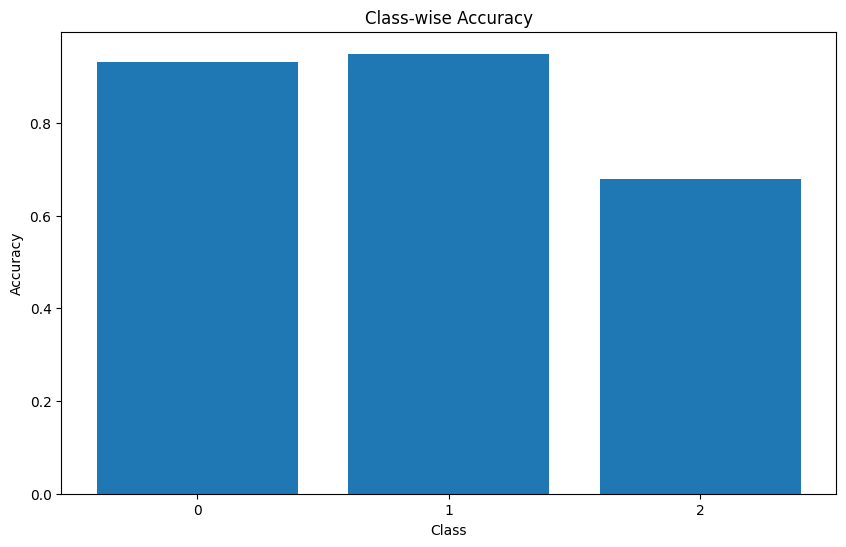

Test Loss: 0.6321, Train Accuracy: 93.57%, Test Accuracy: 91.88%


In [11]:
#Test Loop
all_predictions =[]
all_targets = []

test_accuracies = []
model.eval()
correct_test = 0
total_test = 0
test_loss = 0.0
num_classes = 3

with torch.no_grad():
  for step, batch in enumerate(test_dataloader):
    batch_x, batch_y = batch
    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
    batch_y = batch_y.squeeze()

    outputs = model(batch_x)
    test_loss += criterion(outputs, batch_y)


    _, predicted = torch.max(outputs.data, 1)
    y_prediction = predicted.cpu().numpy()
    y_target = batch_y.cpu().numpy()
    total_test += batch_y.size(0)
    print(f'Output Prediction: {predicted}')
    print(f'Target Prediction: {batch_y}')
    correct_test += (predicted == batch_y).sum().item()

    all_predictions.extend(y_prediction)
    all_targets.extend(y_target)

  all_predictions = np.array(all_predictions)
  all_targets = np.array(all_targets)

  class_accuracies = []
  for i in range(num_classes):
    class_indices = np.where(all_targets == i)[0]
    class_accuracy = accuracy_score(all_targets[class_indices], all_predictions[class_indices])
    class_accuracies.append(class_accuracy)

  cm = confusion_matrix(all_targets, all_predictions)
  plt.figure(figsize=(12, 10))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

  test_loss /= len(test_dataloader)
  test_accuracy = 100 * correct_test / total_test
  test_accuracies.append(test_accuracy)

  plt.figure(figsize=(10, 6))
  plt.bar(range(num_classes), class_accuracies)
  plt.xlabel('Class')
  plt.ylabel('Accuracy')
  plt.title('Class-wise Accuracy')
  plt.xticks(range(num_classes))
  plt.show()

  print(f'Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

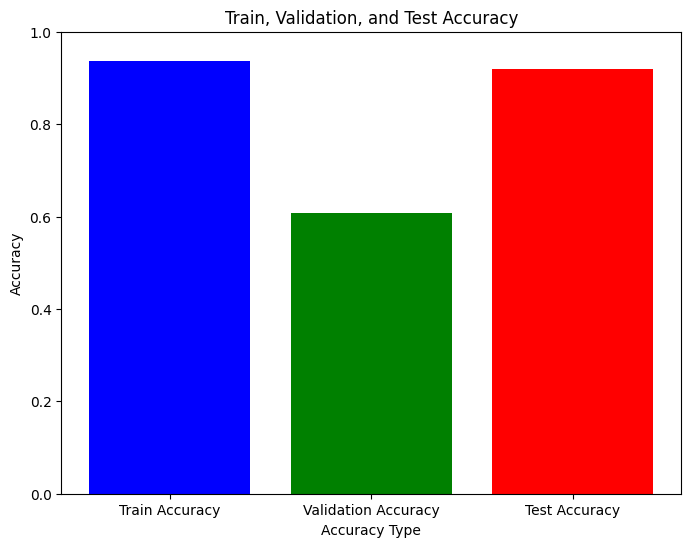

In [12]:
train_accuracy = train_accuracies[-1]/100
validation_accuracy = val_accuracies[-1]/100
test_accuracy = test_accuracies[-1]/100

labels = ['Train Accuracy', 'Validation Accuracy', 'Test Accuracy']
accuracies = [train_accuracy, validation_accuracy, test_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies, color=['blue', 'green', 'red'])
plt.ylim(0, 1)
plt.xlabel('Accuracy Type')
plt.ylabel('Accuracy')
plt.title('Train, Validation, and Test Accuracy')
plt.show()
